In [1]:
# basics
import os, sys

# arrays
import numpy as np
import pandas as pd
import xarray as xr

from datetime import (
    datetime,
    timedelta
)

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, '/home/metocean/geocean-nz-ss')
data_path = '/data' #'/data/storm_surge_data/'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import data_path, default_region_reduced, default_evaluation_metrics, default_region
from sscode.utils import (
    calculate_relative_winds,
    spatial_gradient
)

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
%matplotlib inline

DATA PATH /data


In [2]:
# dataset attrs
datasets_attrs = {
    'era5': ('longitude','latitude',None,'ERA 5 reanalysis','u10','v10'),
    #'cfsr': ('lon','lat',None,'CFSR reanalysis','U_GRD_L103','V_GRD_L103'),
     'cfsr': ('longitude','latitude',None,'CFSR reanalysis','ugrd10m','vgrd10m'),
    'dac': ('longitude','latitude',None,'DAC global reanalysis'),
    'moana': ('lon','lat','site','Moana v2 hindcast'),
    'codec': ('codec_coords_lon','codec_coords_lat','name','CoDEC reanalysis'),
    'uhslc': ('longitude','latitude','name','UHSLC tgs'),
    'linz': ('longitude','latitude','name','LINZ tgs'),
    'other': ('longitude','latitude','name','OTHER tgs'),
    'privtgs': ('longitude','latitude','name','Private tgs')
}


First we load the storm surge data for mainland New Zealand only (excluding Chatham and Auckland Islands).
We will work  with the daily maxima. And to each time stamp, we associate the the maximum storm surge for the following 24 hours.

In [3]:
ss_dset = xr.open_zarr(os.path.join(data_path, 'storm_surge_data/moana_hindcast_v2/moana_coast.zarr/'))
ss_dset = ss_dset.isel(site=np.logical_and(ss_dset.lat>-50, ss_dset.lon < 180))
predictand = ss_dset.ss\
                    .sel(time=slice(datetime(1994,12,1), datetime(2017,2,1,1)))\
                    .drop_duplicates('time')\
                    .chunk(dict(time=-1))\
                    .interpolate_na(dim='time')\
                    .transpose()\
                    .load()

In [4]:
def get_best_predictor_for_region(region=None,
                                  normalised=True):
    from sscode.utils import spatial_gradient
    from sscode.config import default_region_reduced
    
    pres_vars = ('SLP','longitude','latitude')
    wind_vars = ('wind_proj_mask','longitude','latitude','U_GRD_L103','V_GRD_L103')
    
    if region is None:
        region = default_region_reduced
    
    region_large = ( # Pad to be able to do interpolation
              region[0]-1,
              region[1]+1,
              region[2]-1,
              region[3]+1
            )
    
    print("Loading MSLP")
    pres = xr.open_dataarray(os.path.join(data_path, 'cfsr',
                                          'CFSR_MSLP_1H_1990_2021.nc'))\
             .sel(time=slice(datetime(1994,11,1), datetime(2017,3,1)))\
             .sel({
                    pres_vars[1]:slice(region[0],region[1]),
                    pres_vars[2]:slice(region[2],region[3])
                    })\
             .sortby('longitude',ascending=True)\
             .sortby('latitude',ascending=True).fillna(0.0)
    print("Done")
    
    print("Loading wind")
    wind = xr.open_dataset(os.path.join(data_path, 'cfsr',
                                      'wnd10m/cfsr_wnd_1979_2021.nc'))[[datasets_attrs['cfsr'][4],
                                                                        datasets_attrs['cfsr'][5]]]\
              .rename({
                 datasets_attrs['cfsr'][4]: 'u10m',
                 datasets_attrs['cfsr'][5]: 'v10m'
               })\
              .sel(time=slice(datetime(1994,11,1), datetime(2017,3,1)))\
              .sel({
                 wind_vars[1]:slice(region_large[0],region_large[1]),
                 wind_vars[2]:slice(region_large[2],region_large[3])
               })\
              .sortby(datasets_attrs['cfsr'][0],ascending=True)\
              .sortby(datasets_attrs['cfsr'][1],ascending=True)\
              .fillna(0.0)\
              .interp(coords={wind_vars[1]:pres[pres_vars[1]],
                              wind_vars[2]:pres[pres_vars[2]]})\
              .sel(time=pres.time) # interp to pressure coords 
    print("Done")        
    
    # calculate the gradient                                                            
    print('\n calculating the gradient of the sea-level-pressure fields... \n')
    pres = spatial_gradient(pres,pres_vars[0]) # from utils.py                      
    print('\n pressure/gradient predictor both with shape: \n {} \n'\
            .format(pres[pres_vars[0]].shape))
        
    if normalised:
        all_predictors =\
           xr.concat([
                      (pres.SLP.expand_dims("channel", -1)-pres.SLP.min())/(pres.SLP.max()-pres.SLP.min()),
                      (pres.SLP_gradient.expand_dims("channel", -1)-pres.SLP_gradient.min())/(pres.SLP_gradient.max()-pres.SLP.min()),
                      (wind.u10m.expand_dims("channel", -1)-wind.u10m.min())/(wind.u10m.max()-wind.u10m.min()),
                      (wind.v10m.expand_dims("channel", -1)-wind.v10m.min())/(wind.v10m.max()-wind.v10m.min())   
                     ],
                     "channel").fillna(0)
    else:
        all_predictors = \
           xr.concat([
                      pres.SLP.expand_dims("channel", -1),
                      pres.SLP_gradient.expand_dims("channel", -1),
                      wind.u10m.expand_dims("channel", -1),
                      wind.v10m.expand_dims("channel", -1)  
                     ],
                     "channel").fillna(0)
    
    return all_predictors

In [5]:
all_predictors = get_best_predictor_for_region()

Loading MSLP
Done
Loading wind
Done

 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (195745, 45, 51) 



(-71.0, -19.0)

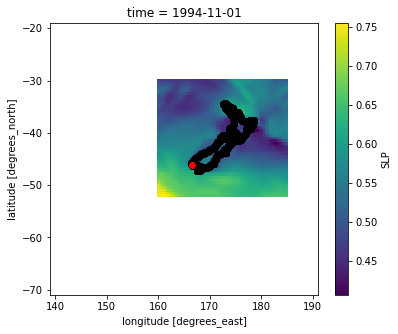

In [35]:
fig, axes = plt.subplots(figsize=(6,5))
all_predictors.isel(time=0,channel=2).plot(ax=axes)
axes.scatter(ss_dset.lon.values, ss_dset.lat.values, color='black')
axes.set_xlim(xmin=default_region[0]-1, xmax=default_region[1]+1)
axes.set_ylim(ymin=default_region[2]-1, ymax=default_region[3]+1)

In [6]:
import tensorflow.compat.v2 as tfv2
# pylint: disable=g-classes-have-attributes

# These functions are adapted from
# https://github.com/keras-team/keras/blob/06ba37b8662dea768b3bc8201942f1eb877708e8/keras/preprocessing/timeseries.py
# The main addition is that they targets have been modified to contain both the input grid and the ss output
# That way it is possible to use the dataset to train both heads of the network
    
def sequences_from_indices(array, indices_ds, start_index, end_index):
  dataset = tfv2.data.Dataset.from_tensors(array[start_index : end_index])
  dataset = tfv2.data.Dataset.zip((dataset.repeat(), indices_ds)).map(
      lambda steps, inds: tfv2.gather(steps, inds),  # pylint: disable=unnecessary-lambda
      num_parallel_calls=tfv2.data.AUTOTUNE)
  return dataset

def timeseries_dataset_from_array_seb(
    data,
    targets,
    targets_2,
    sequence_length,
    weights=None,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None):
  """Creates a dataset of sliding windows over a timeseries provided as array.
  This function takes in a sequence of data-points gathered at
  equal intervals, along with time series parameters such as
  length of the sequences/windows, spacing between two sequence/windows, etc.,
  to produce batches of timeseries inputs and targets.
  Args:
    data: Numpy array or eager tensor
      containing consecutive data points (timesteps).
      Axis 0 is expected to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
      `targets[i]` should be the target
      corresponding to the window that starts at index `i`
      (see example 2 below).
      Pass None if you don't have target data (in this case the dataset will
      only yield the input data).
    sequence_length: Length of the output sequences (in number of timesteps).
    sequence_stride: Period between successive output sequences.
      For stride `s`, output samples would
      start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
    sampling_rate: Period between successive individual timesteps
      within sequences. For rate `r`, timesteps
      `data[i], data[i + r], ... data[i + sequence_length]`
      are used for create a sample sequence.
    batch_size: Number of timeseries samples in each batch
      (except maybe the last one).
    shuffle: Whether to shuffle output samples,
      or instead draw them in chronological order.
    seed: Optional int; random seed for shuffling.
    start_index: Optional int; data points earlier (exclusive)
      than `start_index` will not be used
      in the output sequences. This is useful to reserve part of the
      data for test or validation.
    end_index: Optional int; data points later (exclusive) than `end_index`
      will not be used in the output sequences.
      This is useful to reserve part of the data for test or validation.
  Returns:
    A tfv2.data.Dataset instance. If `targets` was passed, the dataset yields
    tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
    only `batch_of_sequences`.
  Example 1:
  Consider indices `[0, 1, ... 99]`.
  With `sequence_length=10,  sampling_rate=2, sequence_stride=3`,
  `shuffle=False`, the dataset will yield batches of sequences
  composed of the following indices:
  ```
  First sequence:  [0  2  4  6  8 10 12 14 16 18]
  Second sequence: [3  5  7  9 11 13 15 17 19 21]
  Third sequence:  [6  8 10 12 14 16 18 20 22 24]
  ...
  Last sequence:   [78 80 82 84 86 88 90 92 94 96]
  ```
  In this case the last 3 data points are discarded since no full sequence
  can be generated to include them (the next sequence would have started
  at index 81, and thus its last step would have gone over 99).
  Example 2: Temporal regression.
  Consider an array `data` of scalar values, of shape `(steps,)`.
  To generate a dataset that uses the past 10
  timesteps to predict the next timestep, you would use:
  ```python
  input_data = data[:-10]
  targets = data[10:]
  dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
      input_data, targets, sequence_length=10)
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[10])  # Corresponding target: step 10
    break
  ```
  Example 3: Temporal regression for many-to-many architectures.
  Consider two arrays of scalar values `X` and `Y`,
  both of shape `(100,)`. The resulting dataset should consist samples with
  20 timestamps each. The samples should not overlap.
  To generate a dataset that uses the current timestamp
  to predict the corresponding target timestep, you would use:
  ```python
  X = np.arange(100)
  Y = X*2
  sample_length = 20
  input_dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
    X, None, sequence_length=sample_length, sequence_stride=sample_length)
  target_dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
    Y, None, sequence_length=sample_length, sequence_stride=sample_length)
  for batch in zip(input_dataset, target_dataset):
    inputs, targets = batch
    assert np.array_equal(inputs[0], X[:sample_length])
    # second sample equals output timestamps 20-40
    assert np.array_equal(targets[1], Y[sample_length:2*sample_length])
    break
  ```
  """
  if start_index:
    if start_index < 0:
      raise ValueError(f'`start_index` must be 0 or greater. Received: '
                       f'start_index={start_index}')
    if start_index >= len(data):
      raise ValueError(f'`start_index` must be lower than the length of the '
                       f'data. Received: start_index={start_index}, for data '
                       f'of length {len(data)}')
  if end_index:
    if start_index and end_index <= start_index:
      raise ValueError(f'`end_index` must be higher than `start_index`. '
                       f'Received: start_index={start_index}, and '
                       f'end_index={end_index} ')
    if end_index >= len(data):
      raise ValueError(f'`end_index` must be lower than the length of the '
                       f'data. Received: end_index={end_index}, for data of '
                       f'length {len(data)}')
    if end_index <= 0:
      raise ValueError('`end_index` must be higher than 0. '
                       f'Received: end_index={end_index}')

  # Validate strides
  if sampling_rate <= 0:
    raise ValueError(f'`sampling_rate` must be higher than 0. Received: '
                     f'sampling_rate={sampling_rate}')
  if sampling_rate >= len(data):
    raise ValueError(f'`sampling_rate` must be lower than the length of the '
                     f'data. Received: sampling_rate={sampling_rate}, for data '
                     f'of length {len(data)}')
  if sequence_stride <= 0:
    raise ValueError(f'`sequence_stride` must be higher than 0. Received: '
                     f'sequence_stride={sequence_stride}')
  if sequence_stride >= len(data):
    raise ValueError(f'`sequence_stride` must be lower than the length of the '
                     f'data. Received: sequence_stride={sequence_stride}, for '
                     f'data of length {len(data)}')

  if start_index is None:
    start_index = 0
  if end_index is None:
    end_index = len(data)

  # Determine the lowest dtype to store start positions (to lower memory usage).
  num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
  if targets is not None:
    num_seqs = min(num_seqs, len(targets))
  if num_seqs < 2147483647:
    index_dtype = 'int32'
  else:
    index_dtype = 'int64'

  # Generate start positions
  start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
  if shuffle:
    if seed is None:
      seed = np.random.randint(1e6)
    rng = np.random.RandomState(seed)
    rng.shuffle(start_positions)

  sequence_length = tfv2.cast(sequence_length, dtype=index_dtype)
  sampling_rate = tfv2.cast(sampling_rate, dtype=index_dtype)

  positions_ds = tfv2.data.Dataset.from_tensors(start_positions).repeat()

  # For each initial window position, generates indices of the window elements
  indices = tfv2.data.Dataset.zip(
      (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tfv2.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tfv2.data.AUTOTUNE)

  dataset = sequences_from_indices(data, indices, start_index, end_index)
  outputs = [dataset]
  if targets is not None:
    indices = tfv2.data.Dataset.zip(
        (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tfv2.data.AUTOTUNE)
    print(targets.__class__)
    target_ds = sequences_from_indices(
        targets, indices, start_index, end_index)
    
    if targets_2 is not None:
        target_ds_2 = sequences_from_indices(
            targets_2, indices, start_index, end_index)
        outputs.append((target_ds, target_ds_2))
    else:
    #outputs.append((target_ds, dataset))
        outputs.append(target_ds)
    ##dataset = tfv2.data.Dataset.zip((dataset, (target_ds, dataset)))
    
    #outputs.append((target_ds, dataset))
    #outputs.append(target_ds)

  if weights is not None:
    indices = tfv2.data.Dataset.zip(
        (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tfv2.data.AUTOTUNE)
    print(weights.__class__)
    target_weights_dset = sequences_from_indices(
            weights, indices, start_index, end_index)
    
    indices = tfv2.data.Dataset.zip(
      (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tfv2.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tfv2.data.AUTOTUNE)

    ae_weights_dset = sequences_from_indices(np.ones(data.shape[:-1]+(1,)), indices, start_index, end_index)
    outputs.append((target_weights_dset, ae_weights_dset))
    #dataset = tfv2.data.Dataset.zip((dataset, (target_ds, dataset)))
  dataset = tfv2.data.Dataset.zip(tuple(outputs))
  if shuffle:
    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
  dataset = dataset.prefetch(tfv2.data.AUTOTUNE).batch(batch_size)
  return dataset

In [7]:
import tensorflow as tf

to_use=0

gpus = tf.config.list_physical_devices('GPU')

try:
    tf.config.set_visible_devices(gpus[to_use], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("Failed to select GPU")

2 Physical GPUs, 1 Logical GPU


2021-12-16 02:02:14.540113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 02:02:14.541269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 02:02:14.547531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 02:02:14.548346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 02:02:14.548701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [8]:
def get_training_and_validation_sets(predictors,
                                     predictand,
                                     input_sequence_length,
                                     input_sequence_frequency,
                                     lead_time,
                                     target_sequence_frequency,
                                     fold=0,
                                     n_folds=5,
                                     batch_size=32,
                                     print_test=False):
    
    if ( not (predictand.time.values[1:]-predictand.time.values[:-1]).max() ==\
        (predictand.time.values[1:]-predictand.time.values[:-1]).min() ):
        print("Time spacing is not constant in predictand dataset")
        raise
    
    if ( not (predictors.time.values[1:]-predictors.time.values[:-1]).max() ==\
        (predictors.time.values[1:]-predictors.time.values[:-1]).min() ):
            print("Time spacing is not constant in predictor dataset")
            raise
    
    # Find start, end and extent of dataset
    [tstart_predictor, tend_predictor] = predictors.time.values[[0,-1]].astype('datetime64[s]').tolist()
    [tstart_predictand, tend_predictand] = predictand.time.values[[0,-1]].astype('datetime64[s]').tolist()
    tstart = max(tstart_predictand, tstart_predictor)
    tend = min(tend_predictand, tend_predictor)
    time_extent = tend - tstart

    print("Returning fold ",fold," of ", n_folds, " e.g. %2.1f percent training data"%((n_folds-1)/n_folds*100.))

    # Finding time bounds of training data segments
    tstart_1 = tstart
    tend_1 = (tstart + time_extent*((n_folds-1-fold)/n_folds)).replace(second=0, microsecond=0, minute=0)

    tstart_2 = (tstart + time_extent*((n_folds-fold)/n_folds)).replace(second=0, microsecond=0, minute=0)
    tend_2 = tend
    print("")
    
    train_dset = []
    for tstart_train, tend_train in zip([tstart_1, tstart_2],[tend_1, tend_2]):
        if tstart_train != tend_train:
            print("Adding", tstart_train, tend_train,"to training dataset")

            predictor_train =\
                predictors.sel(time=slice(tstart_train,
                                          tend_train-timedelta(hours=(lead_time-target_sequence_frequency))))\
                          .rolling(time=input_sequence_frequency).mean()\
                          .shift(time=-(input_sequence_frequency-1))\
                          .isel(time=slice(0,-(input_sequence_frequency-1)))\
                          .fillna(0)

            ss_train = predictand.sel(time=slice(tstart_train+timedelta(hours=input_sequence_length+lead_time-target_sequence_frequency),
                                      tend_train))\
                                 .chunk(dict(time=-1))\
                                 .interpolate_na(dim='time')\
                                 .rolling(time=target_sequence_frequency).max()\
                                 .shift(time=-(target_sequence_frequency-1))\
                                 .isel(time=slice(0,-(target_sequence_frequency-1)))*100
            
            if len(ss_train.dims) == 1:
                ss_train = ss_train.expand_dims("channel", -1)

            if print_test: # To check indices are fine
                test_dset = timeseries_dataset_from_array_seb(
                    (predictor_train.time.values.astype(np.int)-786412800000000000)//3600000000000,
                    (ss_train.time.values.astype(np.int)-786412800000000000)//3600000000000,
                    targets_2=None,
                    weights=None,
                    sequence_length=int(input_sequence_length/input_sequence_frequency),
                    sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
                    sampling_rate=input_sequence_frequency,
                    batch_size=4, shuffle=True, seed=None, start_index=None, end_index=None
                    )
        
                print("All integer correspond to number of hours with respect to reference date")
                for batch in test_dset:
                    inputs, targets = batch
                    for v1, v2 in zip(inputs, targets):
                        print("Times in:", v1, "Times out:", v2)
                    print_test = False
                    break
                print("")

            train_dset.append(timeseries_dataset_from_array_seb(
                    predictor_train,
                    ss_train,
                    targets_2=None,
                weights=None,
                sequence_length=int(input_sequence_length/input_sequence_frequency),
                sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
                sampling_rate=input_sequence_frequency,
                batch_size=batch_size, shuffle=True, seed=None, start_index=None, end_index=None
                ))
            
    # If multiple segments concatenate them into a single dataset
    if len(train_dset) == 1:
        train_dset = train_dset[0]
    else:
        assert len(train_dset) == 2
        train_dset = train_dset[0].concatenate(train_dset[1])


    # Validation data
    print("Adding", tend_1, tstart_2,"to validation dataset")
    predictor_val = predictors.sel(time=slice(tend_1,
                                              tstart_2-timedelta(hours=(lead_time-target_sequence_frequency))))\
                              .rolling(time=input_sequence_frequency).mean()\
                              .shift(time=-(input_sequence_frequency-1))\
                              .isel(time=slice(0,-(input_sequence_frequency-1)))\
                              .fillna(0)

    ss_val = predictand.sel(time=slice(tend_1+timedelta(hours=input_sequence_length+lead_time-target_sequence_frequency),
                                       tstart_2))\
                       .chunk(dict(time=-1))\
                       .interpolate_na(dim='time')\
                       .rolling(time=target_sequence_frequency).max()\
                       .shift(time=-(target_sequence_frequency-1))\
                       .isel(time=slice(0,-(target_sequence_frequency-1)))*100
    
    if len(ss_val.dims) == 1:
        ss_val = ss_val.expand_dims("channel", -1)


    val_dset = timeseries_dataset_from_array_seb(
        predictor_val,
        ss_val,
        targets_2=None,
        weights=None,
        sequence_length=int(input_sequence_length/input_sequence_frequency),
        sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
        sampling_rate=input_sequence_frequency,
        batch_size=batch_size, shuffle=False, seed=None, start_index=None, end_index=None
    )

    return train_dset, val_dset

In [9]:
from tensorflow.keras.layers import (
    Conv2D,
    Conv3D,
    BatchNormalization,
    MaxPool2D,
    MaxPool3D,
    ConvLSTM2D,
    GlobalMaxPool2D,
    Flatten, Dropout,
    TimeDistributed,
    GRU,
    Dense,
    Dropout,
    Conv1D,
    LSTM,
    Conv2DTranspose,
    Reshape,
    Cropping2D,
    Cropping1D,
    Activation,
    Lambda,
    Concatenate,
    TimeDistributed,
    Flatten,
    Reshape
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.backend import sum

In [12]:
batch_size = 32#4*32

input_sequence_length=3*24 # In hours
input_sequence_frequency=24 # In hours
lead_time=0 # In hours
target_sequence_frequency=24 # In hours

dset_train, dset_val = get_training_and_validation_sets(predictors=all_predictors,
                                                        predictand=predictand,
                                                        input_sequence_length=input_sequence_length,
                                                        input_sequence_frequency=input_sequence_frequency,
                                                        lead_time=lead_time,
                                                        target_sequence_frequency=target_sequence_frequency,
                                                        fold=0,
                                                        n_folds=5,
                                                        batch_size=batch_size,
                                                        print_test=True)

Returning fold  0  of  5  e.g. 80.0 percent training data

Adding 1994-12-01 00:00:00 2012-08-26 10:00:00 to training dataset
SS dimensions (155412, 1358)
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([117977 118001 118025], shape=(3,), dtype=int64) Times out: tf.Tensor(118025, shape=(), dtype=int64)
Times in: tf.Tensor([139301 139325 139349], shape=(3,), dtype=int64) Times out: tf.Tensor(139349, shape=(), dtype=int64)
Times in: tf.Tensor([108241 108265 108289], shape=(3,), dtype=int64) Times out: tf.Tensor(108289, shape=(), dtype=int64)
Times in: tf.Tensor([89853 89877 89901], shape=(3,), dtype=int64) Times out: tf.Tensor(89901, shape=(), dtype=int64)



2021-12-16 02:03:19.346356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-16 02:03:19.433537: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 11418744960 exceeds 10% of free system memory.
2021-12-16 02:03:24.136817: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 11418744960 exceeds 10% of free system memory.


<class 'xarray.core.dataarray.DataArray'>
Adding 2012-08-26 10:00:00 2017-02-01 01:00:00 to validation dataset
<class 'xarray.core.dataarray.DataArray'>


In [192]:
def build_fancy_model_regional(shape_in,
                               nbout=1):

    inputs = tf.keras.Input(shape=shape_in)
    
    conv_1 = TimeDistributed(Conv2D(6, (3,3), padding='same', activation='relu'))(inputs)
    conv_2 = TimeDistributed(Conv2D(12, (3,3), padding='same', activation='relu'))(conv_1)
    conv_3 = TimeDistributed(Conv2D(24, (3,3), padding='same', activation='relu'))(conv_2)
    
    cnn_outputs = Concatenate(axis=-1)([conv_3, inputs])
    
    cnn_outputs = TimeDistributed(Conv2D(24, (1,1), padding='same', activation='linear'))(cnn_outputs)
    
    pool_1 = TimeDistributed(GlobalMaxPool2D())(cnn_outputs)
    
    sum_1 = sum(cnn_outputs, axis=2)
    sum_2 = sum(cnn_outputs, axis=3)
    
    conv_pool_1 = Conv1D(24, (3,))(pool_1)
    
    
    conv_sum_1 = Conv2D(24, (3,3))(sum_1)
    conv_sum_2 = Conv2D(24, (3,3))(sum_2)
    
    conv_pool_1 = Reshape(conv_pool_1.shape[1:-1]+(1,)+conv_pool_1.shape[-1:])(conv_pool_1)
    
    concat_2 = Concatenate(axis=2)([conv_sum_1, conv_sum_2, conv_pool_1])
        
    flat = Flatten()(concat_2)

    dense_1 = Dense(48, #48,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                    )(flat)
    
    dropout_1 = Dropout(0.2)(dense_1)
    
    out = Dense(nbout,
                activation='linear',
                use_bias=True)(dropout_1)

    model = Model(inputs=inputs, outputs=out)

    print(model.summary())
    
    return model

In [14]:
shape_in=(int(input_sequence_length/input_sequence_frequency),) + dset_train.element_spec[0].shape[2:]
fancy_model_cnn_regional = build_fancy_model_cnn(shape_in=shape_in,
                                                 nbout=dset_train.element_spec[1].shape[1])

(None, 3, 45, 51, 24) (None, 3, 45, 51, 4)
SS (None, 1, 49, 24) (None, 1, 43, 24) (None, 1, 1, 24)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 45, 51, 4 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 3, 45, 51, 6) 222         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 3, 45, 51, 12 660         time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 3, 45, 51, 24 2616        time_distributed_1[0][0]     

In [15]:
optimizer = tf.keras.optimizers.Adam(0.00001)
fancy_model_cnn_regional.compile(
    optimizer,
    loss='mse',
    metrics=['mse', 'mae']
)

In [56]:
history = fancy_model_cnn_regional.fit(dset_train,
                                       validation_data=dset_val,
                                       epochs=50)

Epoch 1/20
4857/4857 [==============================] - 40s 8ms/step - loss: 21.1458 - mse: 21.0840 - mae: 3.5348 - val_loss: 19.5196 - val_mse: 19.4579 - val_mae: 3.4157
Epoch 2/20
4857/4857 [==============================] - 40s 8ms/step - loss: 21.1332 - mse: 21.0714 - mae: 3.5319 - val_loss: 19.4913 - val_mse: 19.4294 - val_mae: 3.4094
Epoch 3/20
4857/4857 [==============================] - 40s 8ms/step - loss: 21.0958 - mse: 21.0339 - mae: 3.5296 - val_loss: 19.5013 - val_mse: 19.4394 - val_mae: 3.4105
Epoch 4/20
4857/4857 [==============================] - 40s 8ms/step - loss: 21.0493 - mse: 20.9873 - mae: 3.5260 - val_loss: 19.5677 - val_mse: 19.5057 - val_mae: 3.4219
Epoch 5/20
4857/4857 [==============================] - 40s 8ms/step - loss: 21.0256 - mse: 20.9635 - mae: 3.5249 - val_loss: 19.3838 - val_mse: 19.3217 - val_mae: 3.4010
Epoch 6/20
4857/4857 [==============================] - 40s 8ms/step - loss: 20.9621 - mse: 20.8999 - mae: 3.5192 - val_loss: 19.4528 - val_mse: 

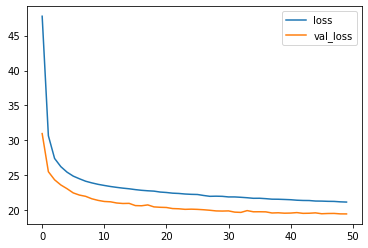

In [55]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
Epoch 50/50
4857/4857 [==============================] - 40s 8ms/step - loss: 19.0807 - mse: 19.0098 - mae: 3.4077 - val_loss: 19.7701 - val_mse: 19.6991 - val_mae: 3.6104

In [58]:
prediction_val_fancy_cnn_regional = fancy_model_cnn_regional.predict(dset_val)

In [59]:
calculate_stats(np.concatenate([y.numpy()[:,0] for x, y in dset_val], axis=0)/100,
                prediction_val_fancy_cnn_regional[:,0]/100)

bias -0.0042181625
si 0.4896816
rmse 0.0510613
rmse_95 0.072939664
rmse_99 0.0956224
pearson 0.850560123474346
pearson_95 0.6053344550186868
pearson_99 0.7074245647638671
rscore 0.720418211374733
rscore_95 -1.4325456443485574
rscore_99 -9.002199847049408
nse [0.72041821]
nse_95 [-1.43254564]
nse_99 [-9.00219985]
kge [0.73942824]
ext_kge_95 [0.53588204]
ext_kge_99 [0.33013048]


In [62]:
def calculate_coast_stats(dset, prediction):
    truth = np.concatenate([y.numpy() for x, y in dset], axis=0)/100.
    prediction = prediction
    
    
    stats = []
    for i in range(prediction.shape[1]):
        title, point_stats = generate_stats(truth[:,i],
                                            prediction[:,i]/100.,
                                            metrics=default_evaluation_metrics,
                                            ext_quantile=default_ext_quantile)
        stats.append(point_stats)
        
    all_stats = {}
    for metric in stats[0].keys():
        all_stats[metric] = [s[metric] for s in stats]
        
    return all_stats

stats_val = calculate_coast_stats(dset_val, prediction_val_fancy_cnn_regional)

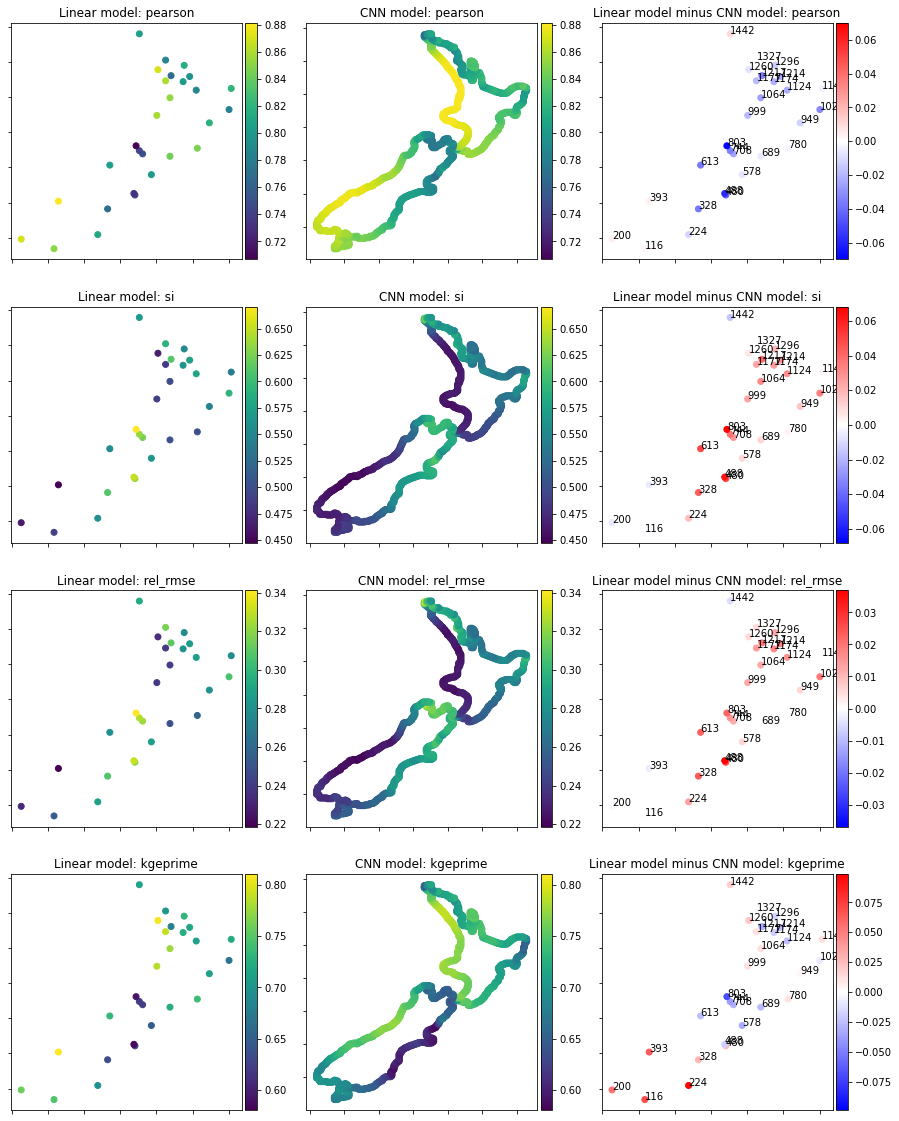

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

linear_results = xr.open_dataset('/home/metocean/geocean-nz-ss/data/statistics/experiments/experiment_linear_final_20211113.nc')
best_linear_results = linear_results.sel(grad=True, winds=True, tlapse=3, region='local_2.5_2.5', tresample='1D')
best_linear_results

metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

sites_linear = [s for s in best_linear_results.site.values if s in predictand.site.values]
lons_linear = ss_dset.sel(site=sites_linear).lon.values
lats_linear = ss_dset.sel(site=sites_linear).lat.values

sites_nn = predictand.site.values
lons_nn = ss_dset.sel(site=sites_nn).lon.values
lats_nn = ss_dset.sel(site=sites_nn).lat.values

fig, axes = plt.subplots(ncols=3, nrows=len(metrics), figsize=(15,5*len(metrics)))

for im, metric in enumerate(metrics):
    
    vals_linear = best_linear_results.sel(site=sites_linear)[metric].values
    vals_nn = stats_val[metric]
    
    vals_diff = vals_linear.squeeze() - np.array([stats_val[metric][np.where(sites_nn==s)[0][0]] for s in sites_linear]).squeeze()
    
    vmin = min(np.min(vals_linear), np.min(vals_nn))
    vmax = max(np.max(vals_linear), np.max(vals_nn))
    
    vdiff_max = np.max(np.abs(vals_diff))

    p=axes[im,0].scatter(lons_linear, lats_linear,
                      c=vals_linear, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Linear model: "+metric)

    p=axes[im,1].scatter(lons_nn, lats_nn,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: "+metric)
    
    p=axes[im,2].scatter(lons_linear, lats_linear,
                         c=vals_diff, cmap='bwr', vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("Linear model minus CNN model: "+metric)
    
    for i, txt in enumerate(sites_linear):
        axes[im,2].annotate(txt, (lons_linear[i], lats_linear[i]))

No handles with labels found to put in legend.


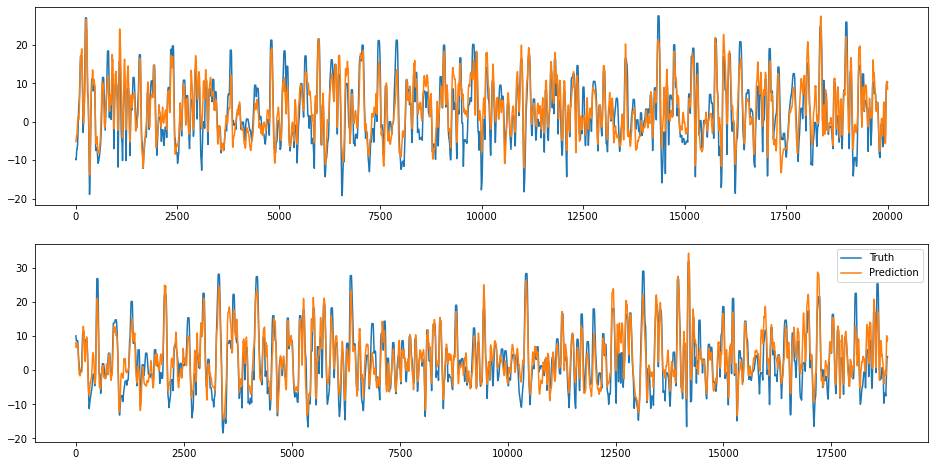

In [53]:
site_id = 393

fig, axes = plt.subplots(nrows=2,figsize=(16,8))
axes[0].plot(np.concatenate([y.numpy()[:,site_id] for x, y in dset_val], axis=0)[0:20000], label='Truth')
axes[0].plot(prediction_val_fancy_cnn_regional[0:20000,site_id], label='Prediction')
plt.legend()
axes[1].plot(np.concatenate([y.numpy()[:,site_id] for x, y in dset_val], axis=0)[20000:], label='Truth')
axes[1].plot(prediction_val_fancy_cnn_regional[20000:,site_id], label='Prediction')
plt.legend()

No handles with labels found to put in legend.


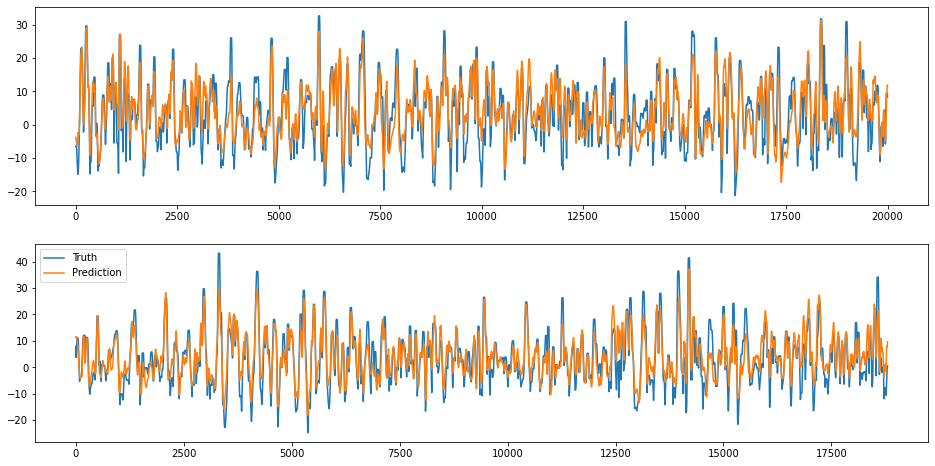

In [54]:
site_id = 708

fig, axes = plt.subplots(nrows=2,figsize=(16,8))
axes[0].plot(np.concatenate([y.numpy()[:,site_id] for x, y in dset_val], axis=0)[0:20000], label='Truth')
axes[0].plot(prediction_val_fancy_cnn_regional[0:20000,site_id], label='Prediction')
plt.legend()
axes[1].plot(np.concatenate([y.numpy()[:,site_id] for x, y in dset_val], axis=0)[20000:], label='Truth')
axes[1].plot(prediction_val_fancy_cnn_regional[20000:,site_id], label='Prediction')
plt.legend()

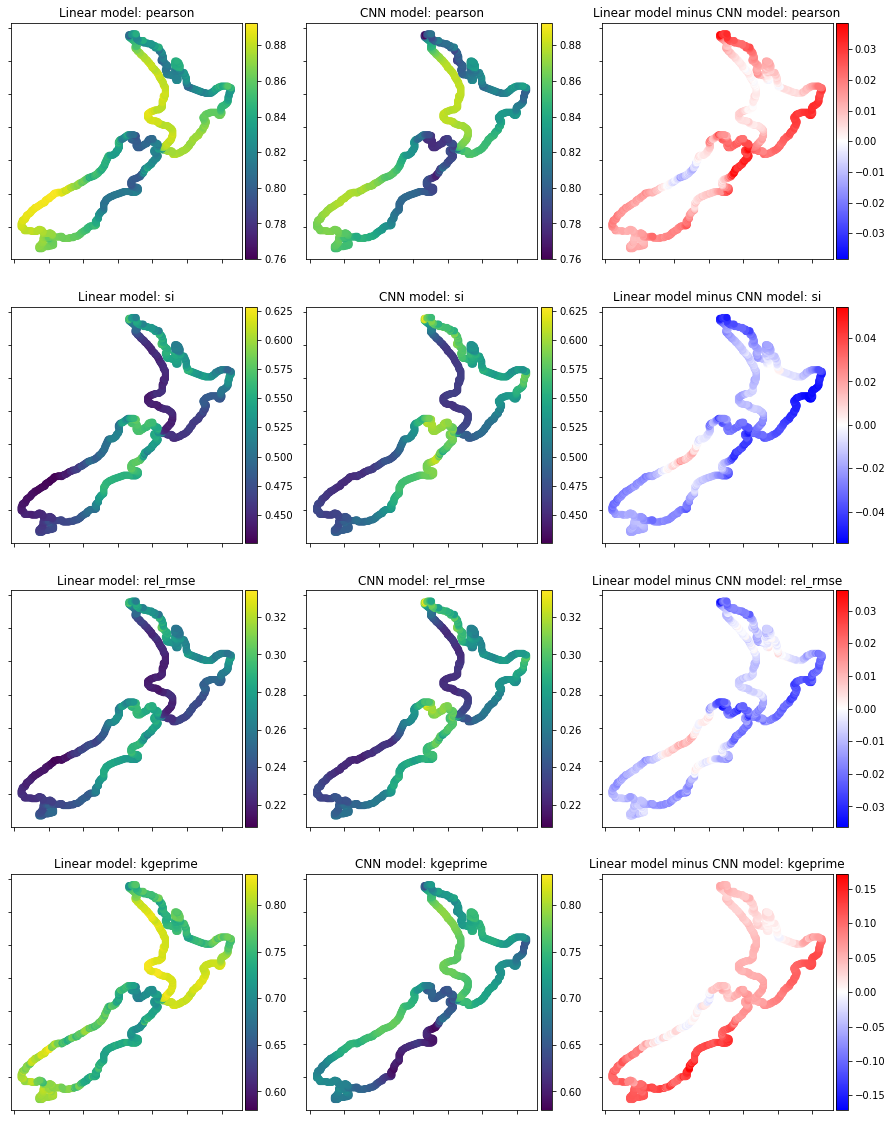

In [211]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

linear_results = xr.open_dataset('/home/metocean/geocean-nz-ss/data/statistics/experiments/linear_superfinal.nc')
best_linear_results = linear_results.squeeze()#.sel(grad=True, winds=True, tlapse=3, region='local_2.5_2.5', tresample='1D')
best_linear_results

metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

sites_linear = [s for s in best_linear_results.site.values if s in predictand.site.values]
lons_linear = ss_dset.sel(site=sites_linear).lon.values
lats_linear = ss_dset.sel(site=sites_linear).lat.values

sites_nn = predictand.site.values
lons_nn = ss_dset.sel(site=sites_nn).lon.values
lats_nn = ss_dset.sel(site=sites_nn).lat.values

fig, axes = plt.subplots(ncols=3, nrows=len(metrics), figsize=(15,5*len(metrics)))

for im, metric in enumerate(metrics):
    
    vals_linear = best_linear_results.sel(site=sites_linear)[metric].values
    vals_nn = stats_val[metric]
    
    vals_diff = vals_linear.squeeze() - np.array([stats_val[metric][np.where(sites_nn==s)[0][0]] for s in sites_linear]).squeeze()
    
    vmin = min(np.min(vals_linear), np.min(vals_nn))
    vmax = max(np.max(vals_linear), np.max(vals_nn))
    
    vdiff_max = np.max(np.abs(vals_diff))

    p=axes[im,0].scatter(lons_linear, lats_linear,
                      c=vals_linear, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Linear model: "+metric)

    p=axes[im,1].scatter(lons_nn, lats_nn,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: "+metric)
    
    p=axes[im,2].scatter(lons_linear, lats_linear,
                         c=vals_diff, cmap='bwr', vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("Linear model minus CNN model: "+metric)

In [120]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, GlobalMaxPooling3D
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def first_block(inputs: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(t)
    return relu_bn(t)

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [199]:
def build_resnet_model(shape_in,
                       nbout=1,
                       cnn_filters=[6, 12, 24],
                       dense=[50]):

    inputs = tf.keras.Input(shape=shape_in)
    
    end_block_1 = inputs
    for n_filter in [6, 12, 24]: # [8, 16, 32]
        conv_1 = TimeDistributed(Conv2D(n_filter, (3,3), strides=2, padding='same', activation='relu'))(end_block_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv_1)
        conv_2 = TimeDistributed(Conv2D(n_filter, (3,3), padding='same', activation='linear'))(bn_1)
    
        res_1 = TimeDistributed(Conv2D(n_filter, (1,1), strides=2, padding='same', activation='linear'))(end_block_1)
    
        add_1 = Concatenate(axis=-1)([conv_2, res_1])
        end_bn_1 = TimeDistributed(ReLU())(add_1)
        end_block_1 = TimeDistributed(BatchNormalization())(end_bn_1)
    
    
    conv3d = Conv3D(n_filter, (3,1,1))(end_block_1)
    
        
    flat = Flatten()(conv3d)

    dropout_1 = flat
    for n_dense in dense:
        dense_1 = Dense(n_dense, #48,
                        activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        )(dropout_1)
        dropout_1 = Dropout(0.2)(dense_1)
    
    out = Dense(nbout,
                activation='linear',
                use_bias=True)(dropout_1)

    model = Model(inputs=inputs, outputs=out)

    print(model.summary())
    
    return model

In [163]:
shape_in=(int(input_sequence_length/input_sequence_frequency),) + dset_train.element_spec[0].shape[2:]
model_resnet = build_resnet_model(shape_in=shape_in,
                                                 nbout=dset_train.element_spec[1].shape[1])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 3, 45, 51, 4 0                                            
__________________________________________________________________________________________________
time_distributed_116 (TimeDistr (None, 3, 23, 26, 8) 296         input_28[0][0]                   
__________________________________________________________________________________________________
time_distributed_117 (TimeDistr (None, 3, 23, 26, 8) 32          time_distributed_116[0][0]       
__________________________________________________________________________________________________
time_distributed_118 (TimeDistr (None, 3, 23, 26, 8) 584         time_distributed_117[0][0]       
____________________________________________________________________________________________

In [134]:
shape_in=(int(input_sequence_length/input_sequence_frequency),) + dset_train.element_spec[0].shape[2:]
model_resnet = build_resnet_model(shape_in=shape_in,
                                                 nbout=dset_train.element_spec[1].shape[1])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 3, 45, 51, 4 0                                            
__________________________________________________________________________________________________
time_distributed_42 (TimeDistri (None, 3, 23, 26, 8) 296         input_21[0][0]                   
__________________________________________________________________________________________________
time_distributed_43 (TimeDistri (None, 3, 23, 26, 8) 32          time_distributed_42[0][0]        
__________________________________________________________________________________________________
time_distributed_44 (TimeDistri (None, 3, 23, 26, 8) 584         time_distributed_43[0][0]        
____________________________________________________________________________________________

In [166]:
optimizer = tf.keras.optimizers.Adam(0.00001)
model_resnet.compile(
    optimizer,
    loss='mse',
    metrics=['mse', 'mae']
)

In [167]:
history_rest = model_resnet.fit(dset_train,
                                       validation_data=dset_val,
                                       epochs=50)

Epoch 1/50
4857/4857 [==============================] - 35s 7ms/step - loss: 45.7078 - mse: 45.6063 - mae: 5.1409 - val_loss: 32.6204 - val_mse: 32.5160 - val_mae: 4.3658
Epoch 2/50
4857/4857 [==============================] - 34s 7ms/step - loss: 30.8256 - mse: 30.7190 - mae: 4.2528 - val_loss: 25.5706 - val_mse: 25.4619 - val_mae: 3.8668
Epoch 3/50
4857/4857 [==============================] - 34s 7ms/step - loss: 26.5719 - mse: 26.4622 - mae: 3.9533 - val_loss: 23.9186 - val_mse: 23.8080 - val_mae: 3.7489
Epoch 4/50
4857/4857 [==============================] - 34s 7ms/step - loss: 24.9605 - mse: 24.8492 - mae: 3.8354 - val_loss: 23.1535 - val_mse: 23.0414 - val_mae: 3.6948
Epoch 5/50
4857/4857 [==============================] - 34s 7ms/step - loss: 23.7941 - mse: 23.6812 - mae: 3.7473 - val_loss: 22.5183 - val_mse: 22.4045 - val_mae: 3.6486
Epoch 6/50
4857/4857 [==============================] - 37s 8ms/step - loss: 22.8768 - mse: 22.7621 - mae: 3.6754 - val_loss: 21.9116 - val_mse: 

Epoch 49/50
4857/4857 [==============================] - 34s 7ms/step - loss: 12.1177 - mse: 11.9637 - mae: 2.6894 - val_loss: 22.8477 - val_mse: 22.6936 - val_mae: 3.7000
Epoch 50/50
4857/4857 [==============================] - 34s 7ms/step - loss: 11.9800 - mse: 11.8257 - mae: 2.6732 - val_loss: 22.9976 - val_mse: 22.8432 - val_mae: 3.7125


In [ ]:
4857/4857 [==============================] - 40s 8ms/step - loss: 20.6508 - mse: 20.5873 - mae: 3.4932 - val_loss: 19.4964 - val_mse: 19.4329 - val_mae: 3.4064

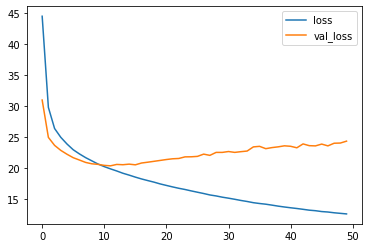

In [156]:
plt.plot(history_rest.history['loss'], label='loss')
plt.plot(history_rest.history['val_loss'], label='val_loss')
plt.legend()

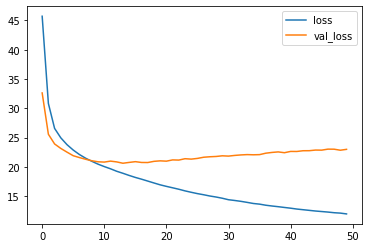

In [168]:
plt.plot(history_rest.history['loss'], label='loss')
plt.plot(history_rest.history['val_loss'], label='val_loss')
plt.legend()

In [141]:
prediction_val_resnet = model_resnet.predict(dset_val)

In [142]:
stats_val_resnet = calculate_coast_stats(dset_val, prediction_val_resnet)

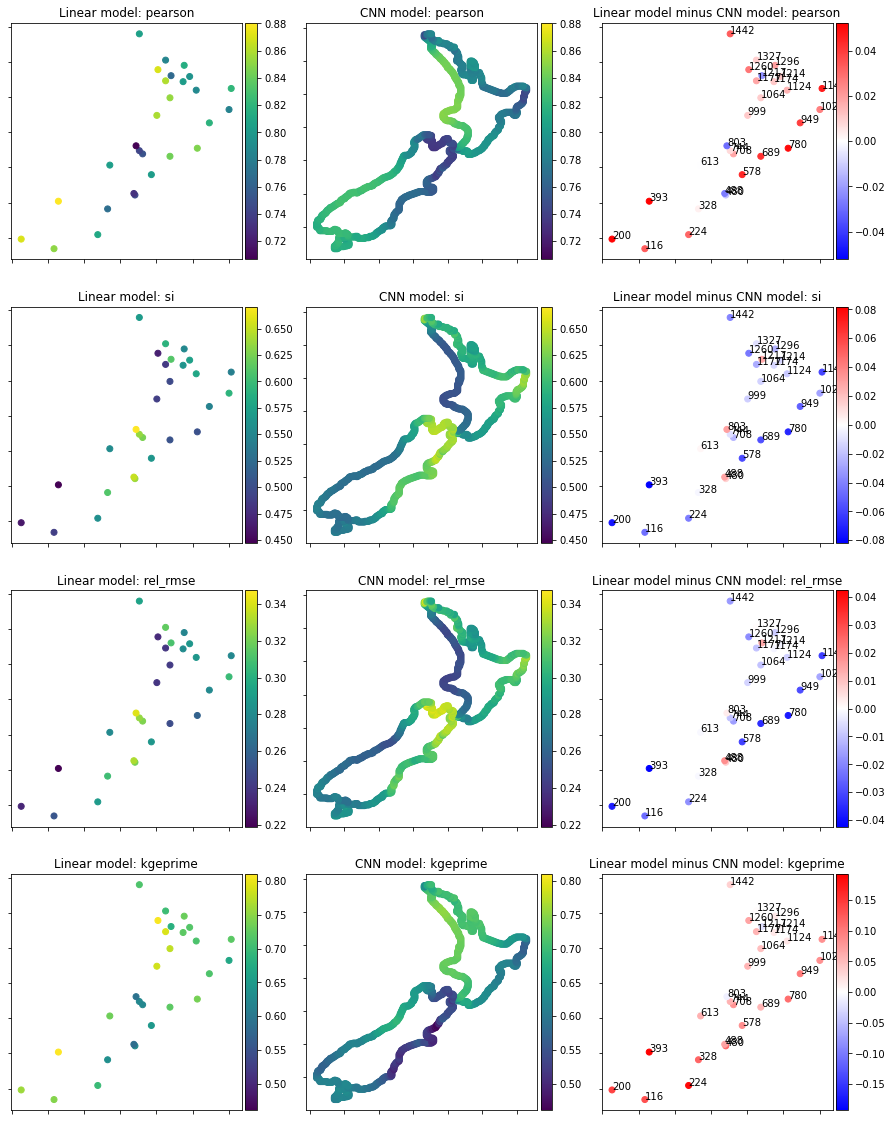

In [143]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

linear_results = xr.open_dataset('/home/metocean/geocean-nz-ss/data/statistics/experiments/experiment_linear_final_20211113.nc')
best_linear_results = linear_results.sel(grad=True, winds=True, tlapse=3, region='local_2.5_2.5', tresample='1D')
best_linear_results

metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

sites_linear = [s for s in best_linear_results.site.values if s in predictand.site.values]
lons_linear = ss_dset.sel(site=sites_linear).lon.values
lats_linear = ss_dset.sel(site=sites_linear).lat.values

sites_nn = predictand.site.values
lons_nn = ss_dset.sel(site=sites_nn).lon.values
lats_nn = ss_dset.sel(site=sites_nn).lat.values

fig, axes = plt.subplots(ncols=3, nrows=len(metrics), figsize=(15,5*len(metrics)))

for im, metric in enumerate(metrics):
    
    vals_linear = best_linear_results.sel(site=sites_linear)[metric].values
    vals_nn = stats_val_resnet[metric]
    
    vals_diff = vals_linear.squeeze() - np.array([stats_val_resnet[metric][np.where(sites_nn==s)[0][0]] for s in sites_linear]).squeeze()
    
    vmin = min(np.min(vals_linear), np.min(vals_nn))
    vmax = max(np.max(vals_linear), np.max(vals_nn))
    
    vdiff_max = np.max(np.abs(vals_diff))

    p=axes[im,0].scatter(lons_linear, lats_linear,
                      c=vals_linear, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Linear model: "+metric)

    p=axes[im,1].scatter(lons_nn, lats_nn,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: "+metric)
    
    p=axes[im,2].scatter(lons_linear, lats_linear,
                         c=vals_diff, cmap='bwr', vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("Linear model minus CNN model: "+metric)
    
    for i, txt in enumerate(sites_linear):
        axes[im,2].annotate(txt, (lons_linear[i], lats_linear[i]))
        
# Comparison standard CNN with multilinear model

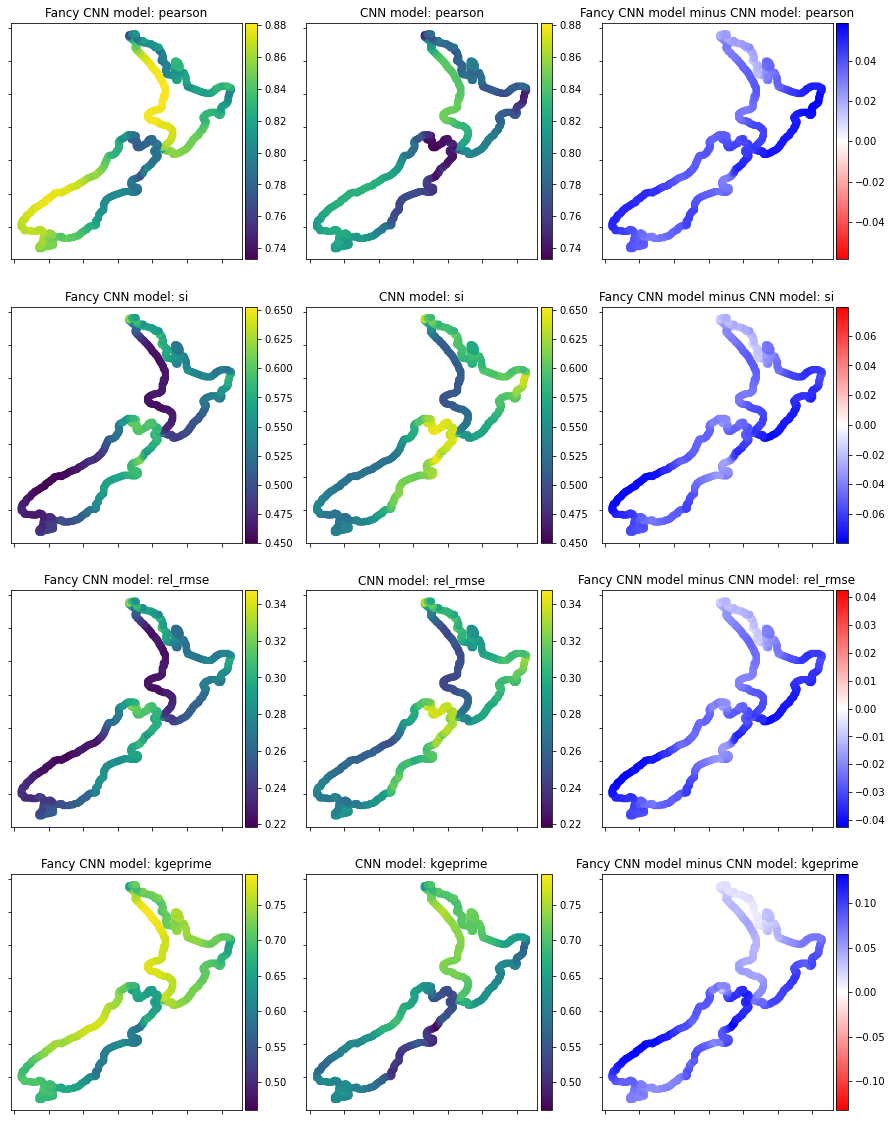

In [155]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

sites = predictand.site.values
lons = ss_dset.sel(site=sites).lon.values
lats = ss_dset.sel(site=sites).lat.values

fig, axes = plt.subplots(ncols=3, nrows=len(metrics), figsize=(15,5*len(metrics)))

for im, metric in enumerate(metrics):
    
    cmap = 'bwr_r'
    if metric in ['si', 'rel_rmse']:
        cmap = 'bwr'
    
    vals_fancy = stats_val[metric]
    vals_nn = stats_val_resnet[metric]
    
    vals_diff = np.array(stats_val[metric]).squeeze()\
                 - np.array(stats_val_resnet[metric]).squeeze()
    
    vmin = min(np.min(vals_fancy), np.min(vals_nn))
    vmax = max(np.max(vals_fancy), np.max(vals_nn))
    
    vdiff_max = np.max(np.abs(vals_diff))

    p=axes[im,0].scatter(lons, lats,
                      c=vals_fancy, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Fancy CNN model: "+metric)

    p=axes[im,1].scatter(lons, lats,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: "+metric)
    
    p=axes[im,2].scatter(lons, lats,
                         c=vals_diff, cmap=cmap, vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("Fancy CNN model minus CNN model: "+metric)
        
# Comparison with fancy nn

In [194]:
prediction_val_last = model_resnet.predict(dset_val)

In [195]:
stats_val_last = calculate_coast_stats(dset_val, prediction_val_last)

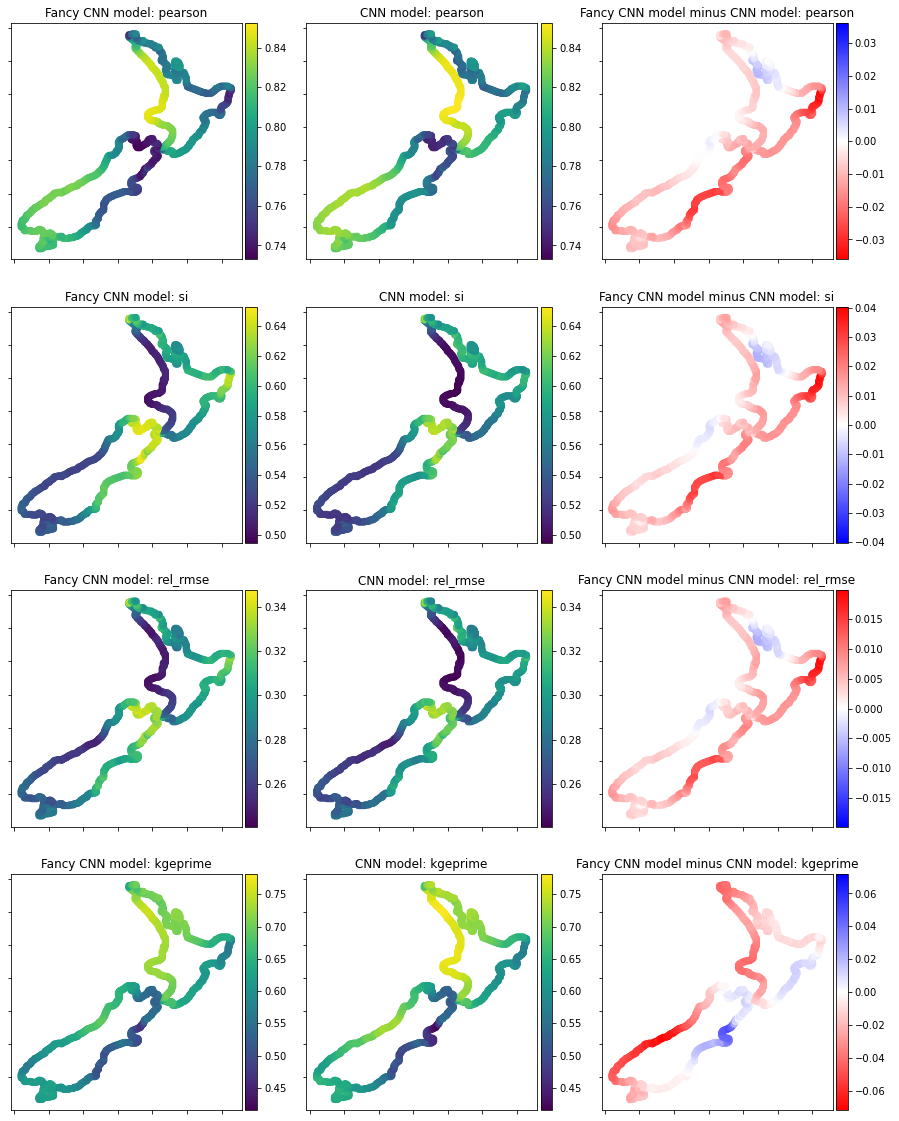

In [198]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

sites = predictand.site.values
lons = ss_dset.sel(site=sites).lon.values
lats = ss_dset.sel(site=sites).lat.values

fig, axes = plt.subplots(ncols=3, nrows=len(metrics), figsize=(15,5*len(metrics)))

stats_val1 = stats_val_resnet
stats_val2 = stats_val_last

for im, metric in enumerate(metrics):
    
    cmap = 'bwr_r'
    if metric in ['si', 'rel_rmse']:
        cmap = 'bwr'
    
    vals_fancy = stats_val1[metric]
    vals_nn = stats_val2[metric]
    
    vals_diff = np.array(stats_val1[metric]).squeeze()\
                 - np.array(stats_val2[metric]).squeeze()
    
    vmin = min(np.min(vals_fancy), np.min(vals_nn))
    vmax = max(np.max(vals_fancy), np.max(vals_nn))
    
    vdiff_max = np.max(np.abs(vals_diff))

    p=axes[im,0].scatter(lons, lats,
                      c=vals_fancy, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Fancy CNN model: "+metric)

    p=axes[im,1].scatter(lons, lats,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: "+metric)
    
    p=axes[im,2].scatter(lons, lats,
                         c=vals_diff, cmap=cmap, vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("Fancy CNN model minus CNN model: "+metric)
        
# Comparison with fancy nn

In [200]:
results={}
for cnn_filters in [ [4,8,12], [6,12,24], [8,16,24], [8,8,8], [4,8], [6,12], [8,16], [8,8] ]:
    for dense in [[10], [20], [50], [10,10], [20,20], [50, 50]]:

        build_resnet_model(shape_in,
                           nbout=1,
                           cnn_filters=[6, 12, 24],
                           dense=[50])

        shape_in=(int(input_sequence_length/input_sequence_frequency),) + dset_train.element_spec[0].shape[2:]
        model_resnet = build_resnet_model(shape_in=shape_in,
                                          nbout=dset_train.element_spec[1].shape[1],
                                          cnn_filters=cnn_filters,
                                          dense=dense)
        optimizer = tf.keras.optimizers.Adam(0.00001)
        model_resnet.compile(
            optimizer,
            loss='mse',
            metrics=['mse', 'mae']
        )
                   
        cnn_config = "_".join([str(i) for i in cnn_filters])
        dense_config = "_".join([str(i) for i in dense])
        
        results[cnn_config][dense_config]['history'] = model_resnet.fit(dset_train,
                                                                        validation_data=dset_val,
                                                                        epochs=50)
        
        prediction_val_resnet = model_resnet.predict(dset_val)
        results[cnn_config][dense_config]['stats_val'] = calculate_coast_stats(dset_val, prediction_val_resnet)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 3, 45, 51, 4 0                                            
__________________________________________________________________________________________________
time_distributed_194 (TimeDistr (None, 3, 23, 26, 6) 222         input_41[0][0]                   
__________________________________________________________________________________________________
time_distributed_195 (TimeDistr (None, 3, 23, 26, 6) 24          time_distributed_194[0][0]       
__________________________________________________________________________________________________
time_distributed_196 (TimeDistr (None, 3, 23, 26, 6) 330         time_distributed_195[0][0]       
___________________________________________________________________________________________

Epoch 1/50
4857/4857 [==============================] - 42s 8ms/step - loss: 53.3148 - mse: 53.2920 - mae: 5.5816 - val_loss: 39.2757 - val_mse: 39.2512 - val_mae: 4.8313
Epoch 2/50
4857/4857 [==============================] - 40s 8ms/step - loss: 42.5563 - mse: 42.5316 - mae: 5.0374 - val_loss: 38.3924 - val_mse: 38.3677 - val_mae: 4.7739
Epoch 3/50
4857/4857 [==============================] - 40s 8ms/step - loss: 40.9689 - mse: 40.9438 - mae: 4.9350 - val_loss: 36.8284 - val_mse: 36.8028 - val_mae: 4.6683
Epoch 4/50
4857/4857 [==============================] - 41s 8ms/step - loss: 38.4830 - mse: 38.4567 - mae: 4.7715 - val_loss: 33.4761 - val_mse: 33.4488 - val_mae: 4.4381
Epoch 5/50
4857/4857 [==============================] - 41s 8ms/step - loss: 35.9132 - mse: 35.8852 - mae: 4.5996 - val_loss: 31.4178 - val_mse: 31.3892 - val_mae: 4.2959
Epoch 6/50
4857/4857 [==============================] - 40s 8ms/step - loss: 34.7457 - mse: 34.7165 - mae: 4.5228 - val_loss: 30.7195 - val_mse: 

Epoch 49/50
4857/4857 [==============================] - 34s 7ms/step - loss: 20.9497 - mse: 20.8966 - mae: 3.4934 - val_loss: 25.5121 - val_mse: 25.4588 - val_mae: 3.9099
Epoch 50/50
4857/4857 [==============================] - 34s 7ms/step - loss: 20.8670 - mse: 20.8135 - mae: 3.4846 - val_loss: 25.3186 - val_mse: 25.2650 - val_mae: 3.8966


KeyError: '4_8_12'

In [ ]:
resu

In [201]:
prediction_old = fancy_model_cnn_regional.predict(dset_val)

In [203]:
stats_val_old = calculate_coast_stats(dset_val, prediction_old)

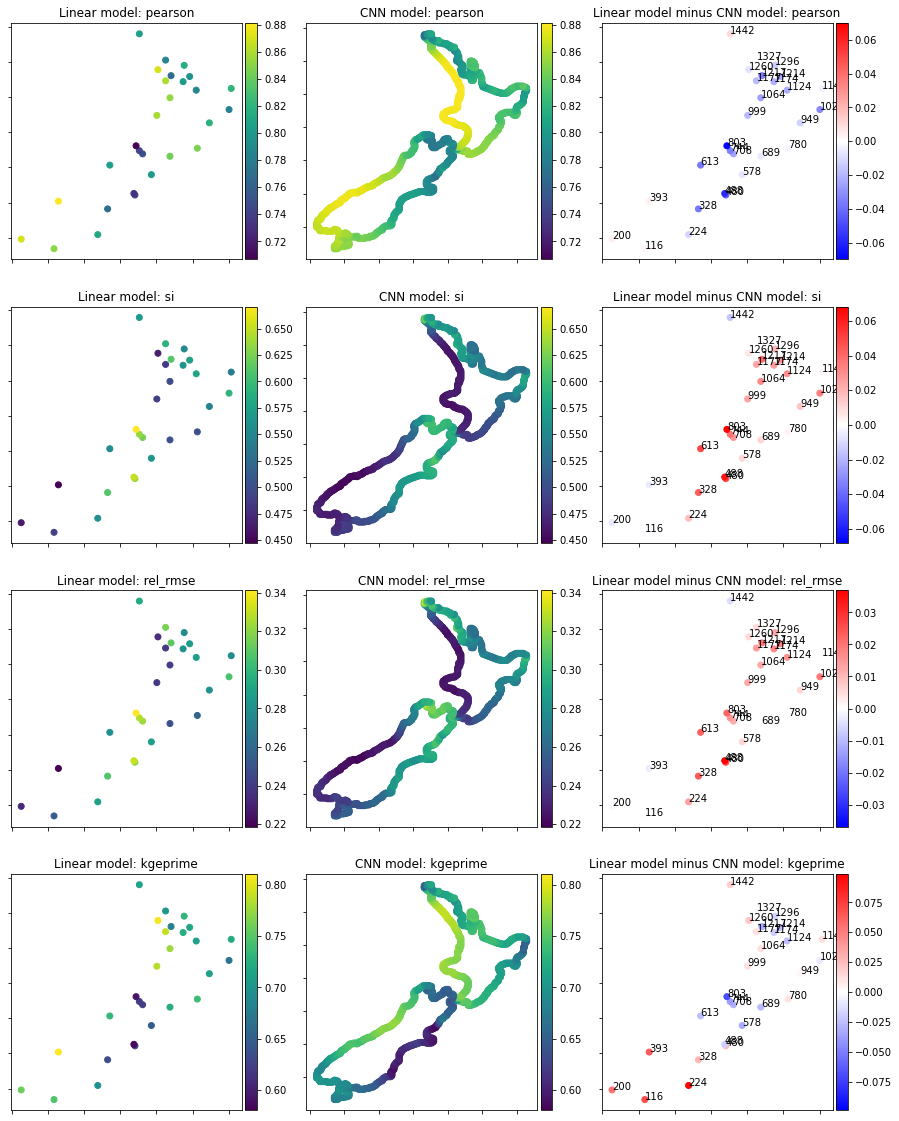

In [204]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

linear_results = xr.open_dataset('/home/metocean/geocean-nz-ss/data/statistics/experiments/experiment_linear_final_20211113.nc')
best_linear_results = linear_results.sel(grad=True, winds=True, tlapse=3, region='local_2.5_2.5', tresample='1D')
best_linear_results

metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

sites_linear = [s for s in best_linear_results.site.values if s in predictand.site.values]
lons_linear = ss_dset.sel(site=sites_linear).lon.values
lats_linear = ss_dset.sel(site=sites_linear).lat.values

sites_nn = predictand.site.values
lons_nn = ss_dset.sel(site=sites_nn).lon.values
lats_nn = ss_dset.sel(site=sites_nn).lat.values

fig, axes = plt.subplots(ncols=3, nrows=len(metrics), figsize=(15,5*len(metrics)))

for im, metric in enumerate(metrics):
    
    vals_linear = best_linear_results.sel(site=sites_linear)[metric].values
    vals_nn = stats_val_old[metric]
    
    vals_diff = vals_linear.squeeze() - np.array([stats_val_old[metric][np.where(sites_nn==s)[0][0]] for s in sites_linear]).squeeze()
    
    vmin = min(np.min(vals_linear), np.min(vals_nn))
    vmax = max(np.max(vals_linear), np.max(vals_nn))
    
    vdiff_max = np.max(np.abs(vals_diff))

    p=axes[im,0].scatter(lons_linear, lats_linear,
                      c=vals_linear, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Linear model: "+metric)

    p=axes[im,1].scatter(lons_nn, lats_nn,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: "+metric)
    
    p=axes[im,2].scatter(lons_linear, lats_linear,
                         c=vals_diff, cmap='bwr', vmin=-vdiff_max, vmax=vdiff_max)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("Linear model minus CNN model: "+metric)
    
    for i, txt in enumerate(sites_linear):
        axes[im,2].annotate(txt, (lons_linear[i], lats_linear[i]))
        
# Comparison standard CNN with multilinear model

In [205]:
fancy_model_cnn_regional.save('/home/metocean/fancy_model_sav')

INFO:tensorflow:Assets written to: /home/metocean/fancy_model_sav/assets


In [206]:
fancy_model_cnn_regional.save_spec('/home/metocean/fancy_model_sav.spec')

([TensorSpec(shape=(None, 3, 45, 51, 4), dtype=tf.float32, name='input_1')],
 {})

In [207]:
fancy_model_cnn_regional.save_weights('/home/metocean/fancy_model_sav.weight')

In [208]:
shape_in=(int(input_sequence_length/input_sequence_frequency),) + dset_train.element_spec[0].shape[2:]
fancy_model_redo = build_fancy_model_cnn(shape_in=shape_in,
                                         nbout=dset_train.element_spec[1].shape[1])

(None, 3, 45, 51, 24) (None, 3, 45, 51, 4)
SS (None, 1, 49, 24) (None, 1, 43, 24) (None, 1, 1, 24)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 3, 45, 51, 4 0                                            
__________________________________________________________________________________________________
time_distributed_230 (TimeDistr (None, 3, 45, 51, 6) 222         input_43[0][0]                   
__________________________________________________________________________________________________
time_distributed_231 (TimeDistr (None, 3, 45, 51, 12 660         time_distributed_230[0][0]       
__________________________________________________________________________________________________
time_distributed_232 (TimeDistr (None, 3, 45, 51, 24 2616        time_distributed_231[0][0]

In [209]:
optimizer = tf.keras.optimizers.Adam(0.00001)
fancy_model_redo.compile(
    optimizer,
    loss='mse',
    metrics=['mse', 'mae']
)

In [210]:
history_redo = fancy_model_redo.fit(dset_train,
                                    validation_data=dset_val,
                                    epochs=50)

Epoch 1/50
4857/4857 [==============================] - 47s 9ms/step - loss: 51.8521 - mse: 51.7794 - mae: 5.4774 - val_loss: 34.7588 - val_mse: 34.6951 - val_mae: 4.4938
Epoch 2/50
4857/4857 [==============================] - 46s 10ms/step - loss: 34.5634 - mse: 34.5022 - mae: 4.4999 - val_loss: 29.3127 - val_mse: 29.2526 - val_mae: 4.1374
Epoch 3/50
4857/4857 [==============================] - 47s 10ms/step - loss: 30.0238 - mse: 29.9642 - mae: 4.1915 - val_loss: 26.1518 - val_mse: 26.0927 - val_mae: 3.9143
Epoch 4/50
4857/4857 [==============================] - 47s 10ms/step - loss: 27.8155 - mse: 27.7567 - mae: 4.0374 - val_loss: 24.8086 - val_mse: 24.7500 - val_mae: 3.8071
Epoch 5/50
4857/4857 [==============================] - 47s 10ms/step - loss: 26.6074 - mse: 26.5485 - mae: 3.9509 - val_loss: 24.0527 - val_mse: 23.9936 - val_mae: 3.7634
Epoch 6/50
4857/4857 [==============================] - 47s 10ms/step - loss: 25.9619 - mse: 25.9025 - mae: 3.9018 - val_loss: 23.3402 - val_